# Домашнее задание "Модели ARIMA"

- Выберите ряд и постройте его модель ARIMA/GARCH.
- **Не обязательное дз.** Попробуйте спрогнозировать график классическим ML

# Решение

In [1]:
import pandas
import numpy
import statsmodels.tsa.api as stats_tsa_api
import statsmodels.api as stats_api
from matplotlib import pyplot

In [2]:
def get_female_births_series():
    return pandas.read_csv('Series/daily-total-female-births-in-cal.csv')['Count']

female_births_series = get_female_births_series()

In [3]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')

    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pandas.Series(
        dftest[0:4],
        index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value

    print(dfoutput)

def show_graphs(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)

    if not isinstance(y, pandas.Series):
        y = pandas.Series(y)

    with pyplot.style.context(style):
        pyplot.figure(figsize=figsize)

        layout = (5, 1)
        ts_ax = pyplot.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = pyplot.subplot2grid(layout, (2, 0))
        pacf_ax = pyplot.subplot2grid(layout, (3, 0))
        qq_ax = pyplot.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        stats_tsa_api.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        stats_tsa_api.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        stats_api.qqplot(y, line='s', ax=qq_ax)

        pyplot.tight_layout()
        pyplot.show()

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


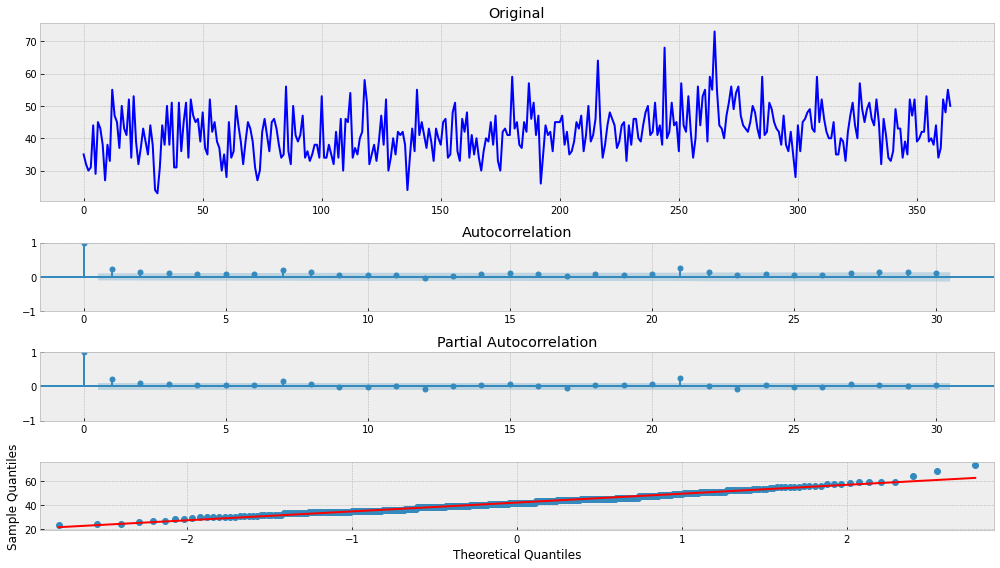

In [4]:
show_graphs(
    female_births_series,
    lags=30)

### GARCH

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


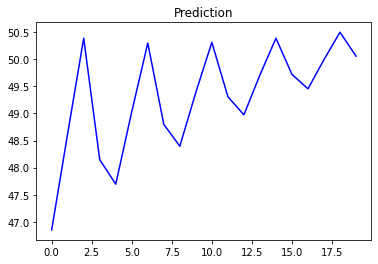

Results of Dickey-Fuller Test:
Test Statistic                  -3.997500
p-value                          0.001424
#Lags Used                       7.000000
Number of Observations Used    317.000000
Critical Value (1%)             -3.451148
Critical Value (5%)             -2.870701
Critical Value (10%)            -2.571651
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


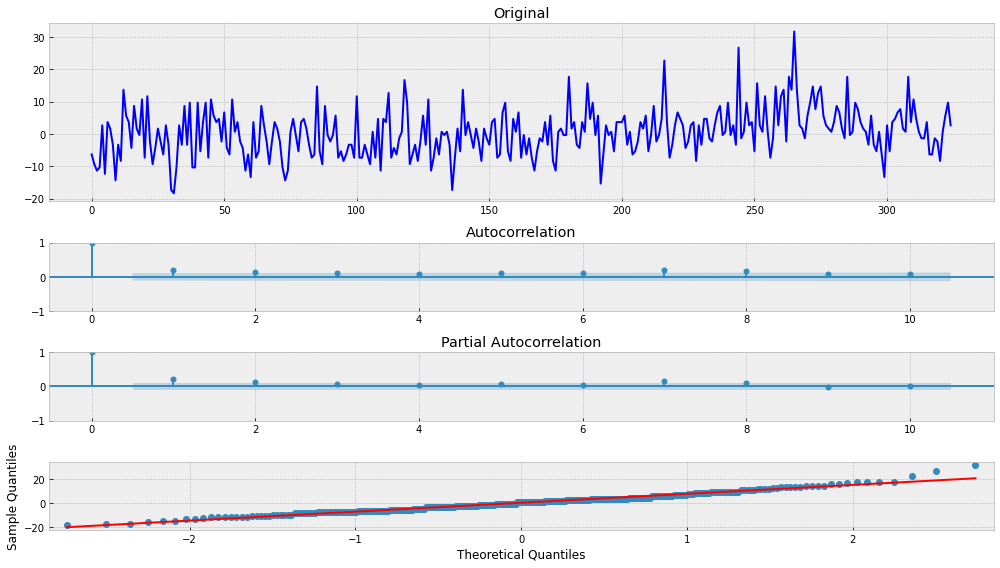

In [5]:
from arch import arch_model

def show_garch_graph(series):
    train_count = 40
    data_arch_model = arch_model(
        series[:-train_count],
        p=4,
        o=0,
        q=4,
        dist='StudentsT')
    fit_data_arch_model = data_arch_model.fit(disp='off')
    forecasts = fit_data_arch_model.forecast(horizon=20)
    forecasts_series = pandas.Series(forecasts.variance.values[-1])

    fit_data_arch_model.plot()

    ts_ax = pyplot.subplot2grid(
        (5, 1),
        (0, 0),
        rowspan=5)
    ts_ax.set_title('Prediction')

    forecasts_series.plot(
        ax=ts_ax,
        color='blue',
        label='Or')
    pyplot.show()

    # The model residuals
    show_graphs(
        fit_data_arch_model.resid,
        lags=10)

show_garch_graph(series=female_births_series)

### ARIMA

In [6]:
def get_best_model(series, epoch=5):
    series = series.copy()
    best_aic = numpy.inf
    best_order = None
    best_arima_model = None

    for index in range(epoch):
        for sub_index in range(epoch):
            for sub_sub_index in range(epoch):
                try:
                    p,d,q = index, sub_index, sub_sub_index
                    arima_model = stats_tsa_api.ARIMA(
                        series,
                        order=(p,d,q))

                    arima_model = arima_model.fit(
                        method='innovations_mle')

                    arima_aic = arima_model.aic

                    if arima_aic < best_aic:
                        best_aic = arima_aic
                        best_order = (index, sub_index, sub_sub_index)
                        best_arima_model = arima_model

                except:
                    print('Error\nindex: {}\nsub_index: {}\nsub_sub_index: {}'.format(index, sub_index, sub_sub_index))
                    continue

    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

    return best_aic, best_order, best_arima_model

aic, order, arima_model = get_best_model(series=female_births_series)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/arima/model.py:403: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  warnings.warn('Provided `endog` series has been differenced'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/arima/model.py:403: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  warnings.warn('Provided `endog` series has been differenced'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/arima/model.py:403: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  warnings.warn('Provided `endog` series has been differenced'
/Library/Frameworks/Python.framework/

Error
index: 2
sub_index: 2
sub_sub_index: 3


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/arima/model.py:403: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  warnings.warn('Provided `endog` series has been differenced'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/arima/model.py:403: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  warnings.warn('Provided `endog` series has been differenced'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/arima/model.py:403: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  warnings.warn('Provided `endog` series has been differenced'
/Library/Frameworks/Python.framework/

aic: 2454.10883 | order: (4, 1, 4)


Results of Dickey-Fuller Test:
Test Statistic                 -19.979800
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


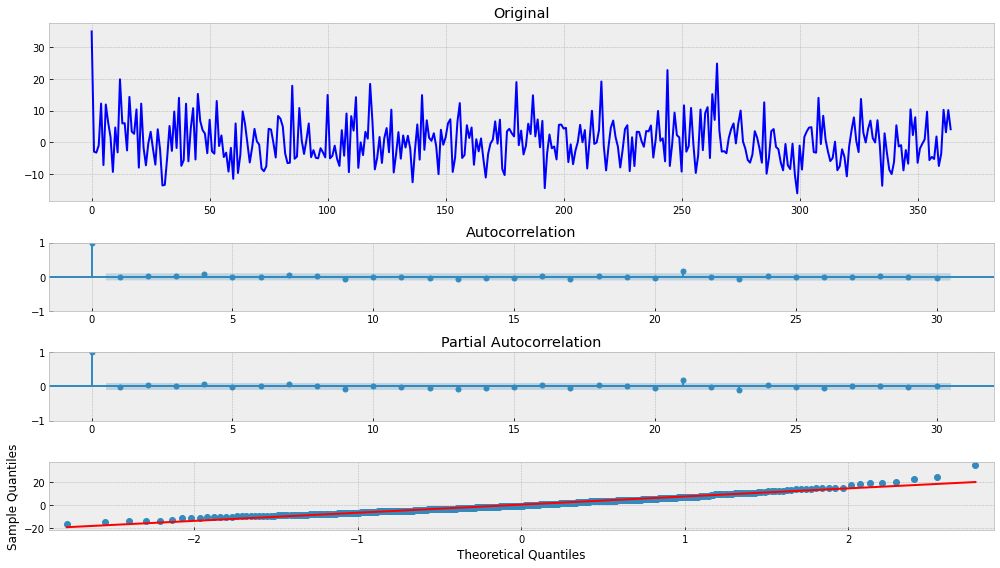

In [7]:
# The model residuals
show_graphs(
    arima_model.resid,
    lags=30)